In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.cluster import DBSCAN
from matplotlib.patches import Rectangle

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\matth\desktop\scg-analyse\venv\lib\site-packages (0.20.3)
Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
data_path = "../data/origineel"

if not Path(data_path).is_dir():
    raise Warning("Data path does not exist")

In [5]:
# Lijst van .csv-bestanden
data_file_paths = [p for p in Path(data_path).iterdir() if p.suffix==".csv"]

In [6]:
# Lees de drie bestanden van het circuit as pandas DataFrame
cableconfig = pd.read_csv(data_file_paths[9], sep=";")
partialdischarges = pd.read_csv(data_file_paths[10], sep=";")
warning = pd.read_csv(data_file_paths[11], sep=";")

In [7]:
# Namen van de kolommen
time_col, location_col, charge_col = partialdischarges.columns

# Check that each row either has location and charge undefinied, or both defined:
for i in np.arange(len(partialdischarges))[np.isnan(partialdischarges[location_col]) != np.isnan(partialdischarges[charge_col])]:
    raise Warning(f"Row {i} has missing values")

# Lijst met bools die aangeeft of er op dat tijdstip een PD was
pd_occured = ~np.isnan(partialdischarges[location_col])

# De drie kolommen; alleen op tijdstippen met PD
locations = partialdischarges[location_col][pd_occured]
charges = partialdischarges[charge_col][pd_occured]
times = partialdischarges[time_col][pd_occured].apply(datetime.datetime.fromisoformat)

In [8]:

H, xedges, yedges = np.histogram2d(locations,locations.index, bins = [1000,100])
weights = H.reshape(1,100000)
data1 = np.mgrid[0:1000, 0:100].reshape(2,-1).T
x = np.concatenate((data1,weights.T), axis = 1)
z = np.array([y for y in x if y[2]>0])
z[:, 2]

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   4.,   5.,   1.,   2.,
         1.,   1.,   6.,   6.,   2.,   1.,   2.,   2.,   1.,   2.,   1.,
         1.,   1.,   1.,   8.,  10.,   2.,   1.,   2.,   3.,   5.,   2.,
         2.,   2.,   1.,   1.,  14.,  16.,   4.,   4.,   5.,  13.,   5.,
         2.,   3.,   3.,   3.,   3.,   7.,   1.,   3.,  36.,  37.,   6.,
         1.,   6.,   7.,   7.,   9.,   3.,   4.,  10.,   2.,   4.,  10.,
         2.,   1.,   1.,  11.,  24.,   9.,   2.,   1.,   1.,   1.,   5.,
        50.,  40.,   8.,   4.,   4.,  17.,  15.,  16.,  10.,  12.,  15.,
        13.,   5.,  83.,  73.,  15.,   5.,  14.,  19.,  33.,  31.,  19.,
        21.,  28.,  26.,  21.,  42.,  15.,   2.,   2.,  11., 173., 106.,
        23.,  10.,  16.,  46.,  55.,  74.,  48.,  30.,  76.,  32.,  45.,
        83.,  21.,  12.,   2.,  19., 315., 140.,  25.,  12.,  37., 113.,
       110., 136., 111., 100., 131.,  58.,  74., 164.,  53.,  27.,   6.,
         1.,   2.,   1.,   1.,  14., 535., 127.,  4

In [9]:
a = np.array([[1,2],[3,4]])
b = np.array([[1,2]])
b.shape

(1, 2)

In [10]:
def DBSCAN1(binAmount,scale):
    # afstanden in bakjes gooien
    H, xedges, yedges = np.histogram2d(locations,locations.index, bins = [scale*binAmount,binAmount])
    
    # het gewicht van ieder bakje is het aantal punten in dat bakje
    weights = H.reshape(1,100000)
    
    # ieder bakje heeft afstand 1 tot zijn horizontale en verticale buren
    data = np.mgrid[0:scale*binAmount, 0:binAmount].reshape(2,-1).T
    x = np.concatenate((data,weights.T), axis = 1)
    z = np.array([y for y in x if y[2]>0])

    # DBSCAN met epsilon = 2, min_samples = 4*10^6/aantal bakjes
    labels = DBSCAN(eps= 2, min_samples=4000000/(scale*binAmount**2)).fit(z[:, [0,1]], sample_weight = z[:, 2] ).labels_ 
    
    # plotten
    colorcycle=["red", "green", "blue", "yellow", "orange", "purple", "pink", "cyan", "steelblue"]
    xlength = max(locations)
    ylength = max(locations.index)
    plt.figure("scatter + rectangles")
    plt.axis([0 , xlength, 0, ylength])
    plt.xlabel("Place")
    plt.ylabel("Time")
    plt.scatter(x = locations,y = locations.index,s = .1)
    for i in range(scale*binAmount**2):
        if labels[i] != -1:
            plt.gca().add_patch(Rectangle((data[i][0]*xlength/(scale*binAmount),data[i][1]*ylength/binAmount), xlength/(scale*binAmount), ylength/binAmount, alpha = .5, facecolor=colorcycle[labels[i]%len(colorcycle)]))
    plt.show()

<IPython.core.display.Javascript object>


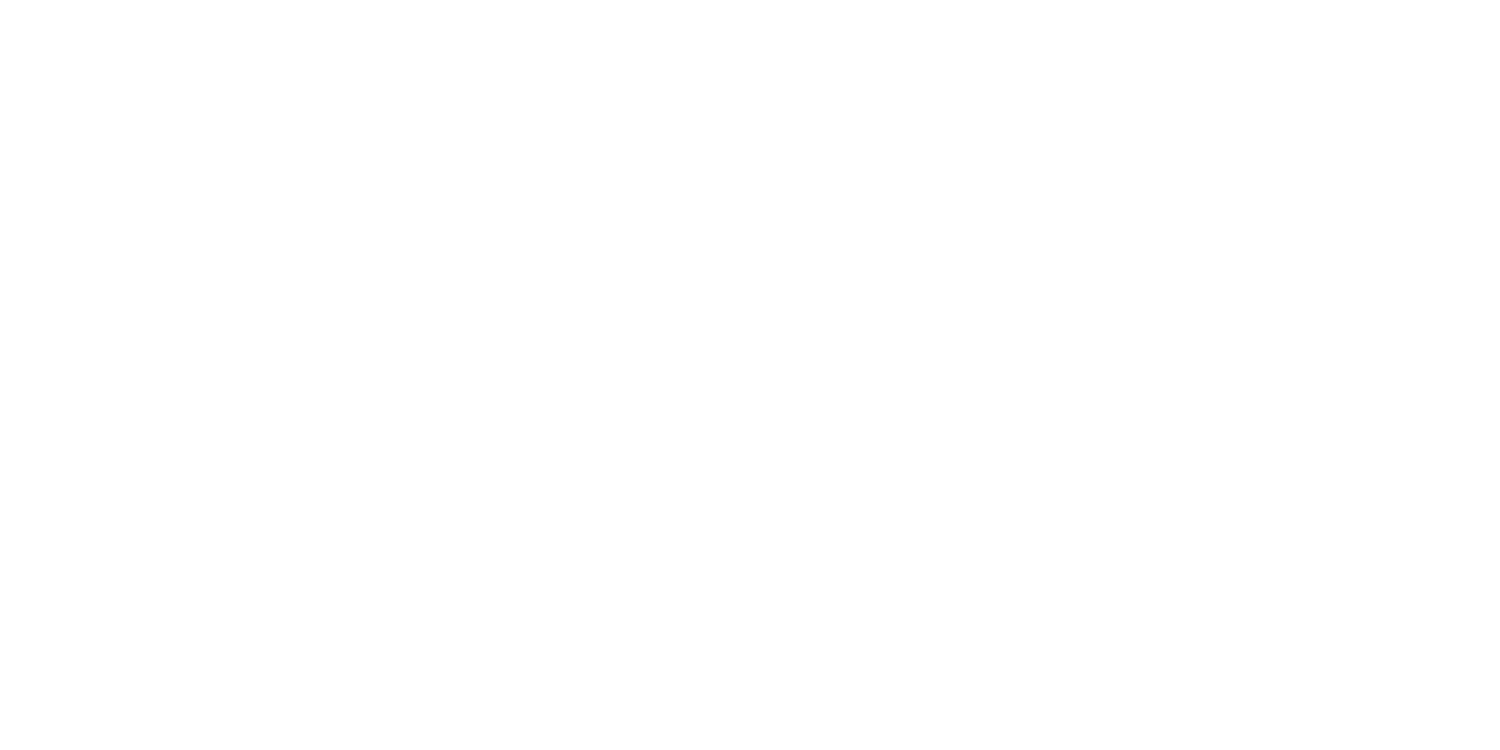

IndexError: index 405 is out of bounds for axis 0 with size 405

In [11]:
%%time
%matplotlib notebook
DBSCAN1(100,10)

<IPython.core.display.Javascript object>


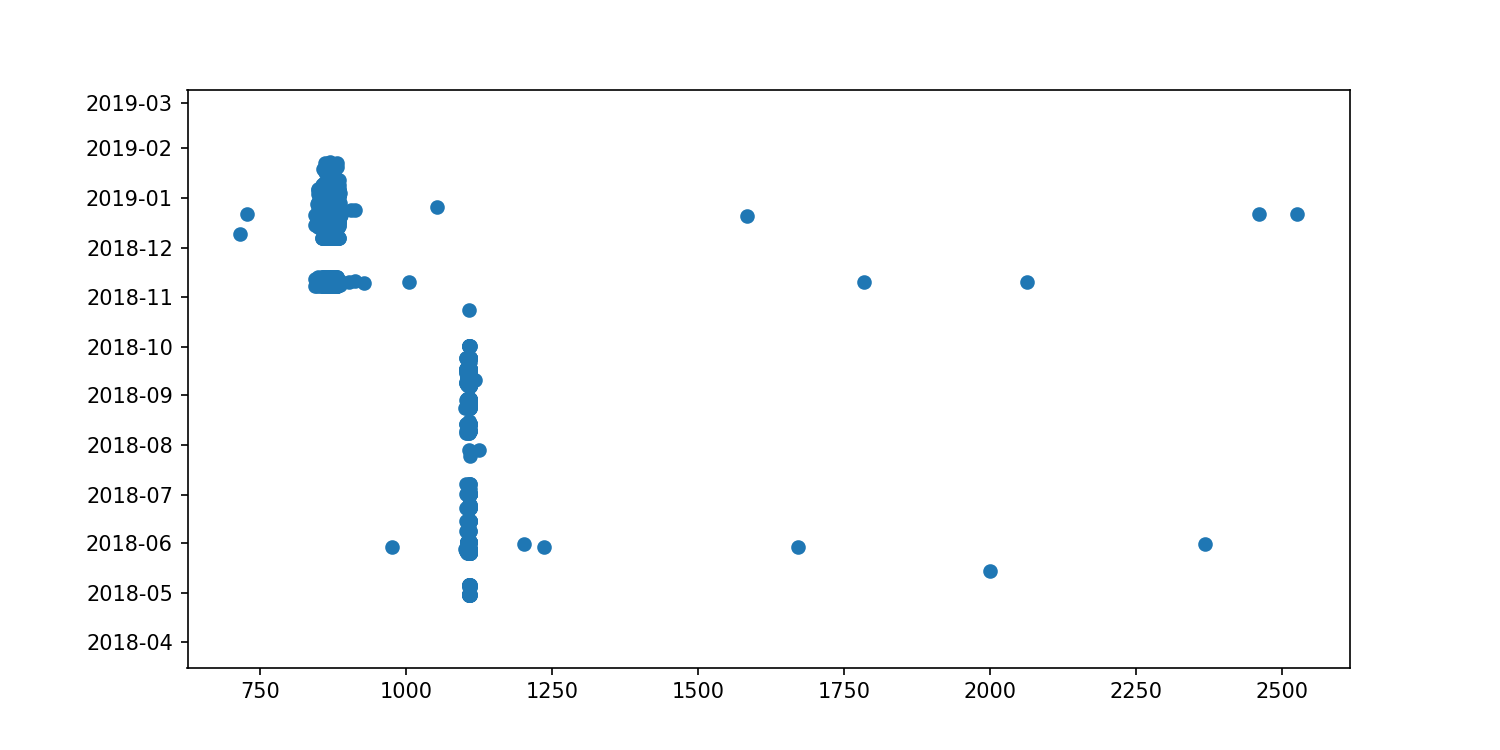

c:\users\matth\desktop\scg-analyse\venv\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [12]:
%matplotlib notebook
plt.scatter(locations,times)

In [13]:
bins=(100, 100)
ranges=((-1,1),(-1,1))
bins = np.asarray(bins).astype(np.int64)
ranges = np.asarray(ranges).astype(np.float64)
    
edges = (np.linspace(*ranges[0,:], bins[0]+1),
         np.linspace(*ranges[1,:], bins[1]+1))
np.random.seed(42)
vals = np.random.normal(size=[2, 1000000]).astype(np.float32)
vals1d = np.random.normal(size=[10000000]).astype(np.float32)

In [14]:
cuts = (vals[0]>=ranges[0,0]) & (vals[0]<ranges[0,1]) & (vals[1]>=ranges[1,0]) & (vals[1]<ranges[1,1])
c = ((vals[0,cuts] - ranges[0,0]) / (ranges[0,1] - ranges[0,0]) * bins[0]).astype(np.int_)
c += bins[0]*((vals[1,cuts] - ranges[1,0]) / (ranges[1,1] - ranges[1,0]) * bins[1]).astype(np.int_)
H = np.bincount(c, minlength=bins[0]*bins[1]).reshape(*bins)
H

array([[23, 17, 21, ..., 23, 17, 20],
       [21, 33, 22, ..., 27, 32, 38],
       [26, 30, 29, ..., 22, 22, 25],
       ...,
       [28, 23, 22, ..., 30, 19, 24],
       [36, 16, 16, ..., 22, 29, 13],
       [26, 22, 26, ..., 23, 25, 20]], dtype=int64)

In [15]:
s= "16/08/2013 09:51:43"
d = datetime.datetime.strptime(s, "%d/%m/%Y %H:%M:%S")
d

datetime.datetime(2013, 8, 16, 9, 51, 43)

In [16]:

x=np.datetime64(int(times[17110].value/1000000000), 's')
x == times[17110]

True

In [17]:
times

17109    2018-04-29 14:53:00
17110    2018-04-29 14:53:00
17111    2018-04-29 14:54:00
17112    2018-04-29 14:54:00
17114    2018-04-29 14:56:00
17115    2018-04-29 14:56:00
17116    2018-04-29 14:57:00
17117    2018-04-29 14:57:00
17121    2018-04-29 15:02:00
17122    2018-04-29 15:02:00
18343    2018-04-30 15:10:00
18344    2018-04-30 15:10:00
18345    2018-04-30 15:11:00
18362    2018-04-30 15:28:00
18363    2018-04-30 15:28:00
24033    2018-05-04 18:33:00
24034    2018-05-04 18:33:00
24035    2018-05-04 18:34:00
25466    2018-05-05 18:37:00
25467    2018-05-05 18:37:00
25468    2018-05-05 18:38:00
25469    2018-05-05 18:38:00
25470    2018-05-05 18:38:00
25471    2018-05-05 18:39:00
25472    2018-05-05 18:39:00
25473    2018-05-05 18:40:00
38357    2018-05-14 22:32:00
53813    2018-05-26 04:00:00
53814    2018-05-26 04:00:00
53815    2018-05-26 04:01:00
                 ...        
346003   2019-01-12 22:33:00
346036   2019-01-12 23:06:00
346105   2019-01-13 00:15:00
346385   2019-

In [181]:
%%time
set(times[times<np.datetime64(times[18343])][times>times[17111]].index)
set(locations)

Wall time: 7.98 ms


numpy.datetime64('2018-04-29T14:53:00')